In [ ]:
# Standard libraries
import os
from glob import glob
import itertools
import pickle

# Basic 3rd party libraries
import pandas as pd
import numpy as np

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# scikit processing
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

# scikit models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# TensorFlow Keras API
from tensorflow.keras.utils import (
    plot_model as tf_plot,
    to_categorical,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy

# TensorFlow Keras model and layers API
from tensorflow.keras.layers import (
    Input,
    Reshape,
    RepeatVector,
    UpSampling2D,
    Flatten,
    Conv1D,
    Conv2D,
    MaxPooling1D,
    MaxPooling2D,
    LSTM,
    ConvLSTM1D,
    ConvLSTM2D,
    Dense,
    Dropout,
    SpatialDropout1D,
    SpatialDropout2D,
    Concatenate,
)
from tensorflow.keras.models import (
    Sequential,
    Model,
    load_model as tf_load_model,
)



## Mounting Google Drive and setting resources path (path to captures)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

resources_dir = '/content/drive/MyDrive/honours/captures'

print(os.path.exists(resources_dir))

Mounted at /content/drive
True


## Setting configs


In [ ]:

# Directory storing the CSI and WLAN captures
resources_dir = '/content/drive/MyDrive/honours/captures'

# Directory to save plots to
plt_dir = '/content/drive/MyDrive/honours/figures/comb'

# Directory to save models to
models_dir = '/content/drive/MyDrive/honours/models/comb'

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300
plt.rcParams["figure.dpi"] = 500 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_qual = "pastel"
cmap_seq = "viridis"
cmap_cycl = "twilight"
cmap_intsy = "Blues"

# Hide warnings
import warnings
warnings.filterwarnings("ignore")


## ML Preprocessing


### Reading in CSI total binned df

In [ ]:
X_csi = pd.read_hdf(
    os.path.join(resources_dir, "total_csi.h5"),
    key="csi",
    mode="r"
)

# SPECIFY FEATURES TO USE:
# Choosing CSI amplitudes of only data subcarriers
nulls = [0, 1, 2, 3, 4, 5, 63, 62, 61, 60, 59, 32]
pilots = [11, 25, 53, 39]
data = [i for i in np.arange(64) if i not in np.concatenate([nulls, pilots])]
X_csi_channels = [f"csi_{i}_a" for i in data]

# Making each row instance's time series vector for each column's measure
X_csi_features = (
    X_csi
    .sort_values("ts_bins")
    .groupby(["devices", "videos", "instances"])
    .agg({i: lambda x: x.values.tolist() for i in X_csi_channels})
)


### Reading in WLAN total binned df

In [ ]:
X_wlan = pd.read_hdf(
    os.path.join(resources_dir, "total_wlan.h5"),
    key="wlan",
    mode="r"
)

# SPECIFY FEATURES TO USE
X_wlan_channels = [
    # (with non-data, data, and all frames)
    # Uplink
    # "frames_up_ndat",
    # "bytes_up_ndat",
    # "frames_up_dat",
    # "bytes_up_dat",
    # "frames_up_all",
    # "bytes_up_all",
    # Downlink
    # "frames_dn_ndat",
    # "bytes_dn_ndat",
    # "frames_dn_dat",
    # "bytes_dn_dat",
    # "frames_dn_all",
    # "bytes_dn_all",
    # All
    # "frames_all_ndat",
    "bytes_all_ndat",
    # "frames_all_dat",
    "bytes_all_dat",
    # "frames_all_all",
    "bytes_all_all",
]

# Making each row instance's time series vector for each column's measure
X_wlan_features = (
    X_wlan
    .sort_values("ts_bins")
    .groupby(["devices", "videos", "instances"])
    .agg({i: lambda x: x.values.tolist() for i in X_wlan_channels})
)


### Merging CSI and WLAN DFs

In [ ]:
X_comb_features = pd.merge(
    X_csi_features,
    X_wlan_features,
    # on=["devices", "videos", "instances"],
    how="inner",
    # suffixes=("_csi", "_wlan"),
    left_index=True,
    right_index=True,
)

X_comb_features

csi_6_a  \
devices    videos instances                                                      
PC 200 cm  Vid 1  cap_0.h5   [463.3955078125, 410.86767578125, 419.50338745...   
                  cap_1.h5   [373.201416015625, 374.0190734863281, 374.8367...   
                  cap_10.h5  [370.64019775390625, 367.80340576171875, 365.2...   
                  cap_11.h5  [377.1904602050781, 355.18804931640625, 352.54...   
                  cap_12.h5  [351.6483459472656, 342.6521911621094, 353.923...   
...                                                                        ...   
RPi4 50 cm Vid 9  cap_95.h5  [407.4381408691406, 426.1487121582031, 403.938...   
                  cap_96.h5  [403.5983581542969, 422.01947021484375, 412.31...   
                  cap_97.h5  [421.2444152832031, 461.130126953125, 413.0690...   
                  cap_98.h5  [410.3595275878906, 447.65704345703125, 414.29...   
                  cap_99.h5  [548.61865234375, 541.0462646484375, 533.47381...   

                                                                       csi_7_a  \
devices    videos instances                                                      
PC 200 cm  Vid 1  cap_0.h5   [479.7345886230469, 426.7371826171875, 433.412...   
                  cap_1.h5   [383.13128662109375, 385.3946228027344, 387.65...   
                  cap_10.h5  [387.8114318847656, 385.60955810546875, 384.35...   
                  cap_11.h5  [394.4790344238281, 374.0491027832031, 369.800...   
                  cap_12.h5  [368.7706604003906, 364.7548828125, 369.353179...   
...                                                                        ...   
RPi4 50 cm Vid 9  cap_95.h5  [407.53387451171875, 429.2345886230469, 404.37...   
                  cap_96.h5  [407.0764465332031, 425.811767578125, 418.5701...   
                  cap_97.h5  [424.0397033691406, 467.08087158203125, 420.41...   
                  cap_98.h5  [414.6687927246094, 451.9546813964844, 422.403...   
                  cap_99.h5  [550.1248779296875, 542.6915283203125, 535.258...   

                                                                       csi_8_a  \
devices    videos instances                                                      
PC 200 cm  Vid 1  cap_0.h5   [500.4700012207031, 449.6867370605469, 453.968...   
                  cap_1.h5   [413.6925048828125, 414.2353210449219, 414.778...   
                  cap_10.h5  [411.32916259765625, 407.28668212890625, 406.8...   
                  cap_11.h5  [420.30303955078125, 396.93035888671875, 393.8...   
                  cap_12.h5  [397.9125061035156, 387.8621520996094, 393.972...   
...                                                                        ...   
RPi4 50 cm Vid 9  cap_95.h5  [410.525634765625, 429.5739440917969, 400.8713...   
                  cap_96.h5  [406.5120544433594, 417.5408935546875, 418.570...   
                  cap_97.h5  [422.285888671875, 463.5692138671875, 420.5769...   
                  cap_98.h5  [413.8819274902344, 451.680419921875, 418.6454...   
                  cap_99.h5  [546.984375, 539.6087036132812, 532.2329711914...   

                                                                       csi_9_a  \
devices    videos instances                                                      
PC 200 cm  Vid 1  cap_0.h5   [521.7802124023438, 465.7176818847656, 470.445...   
                  cap_1.h5   [432.15966796875, 432.9040222167969, 433.64837...   
                  cap_10.h5  [433.880615234375, 424.98779296875, 427.493347...   
                  cap_11.h5  [436.871337890625, 418.0634765625, 411.9932250...   
                  cap_12.h5  [418.1121520996094, 411.3858337402344, 413.358...   
...                                                                        ...   
RPi4 50 cm Vid 9  cap_95.h5  [410.3462219238281, 428.6236267089844, 403.824...   
                  cap_96.h5  [405.16998291015625, 414.1858215332031, 422.73...   
                  cap_97.h5  [422.4645080566406, 4

### Visualising the number of collected traces for different labels

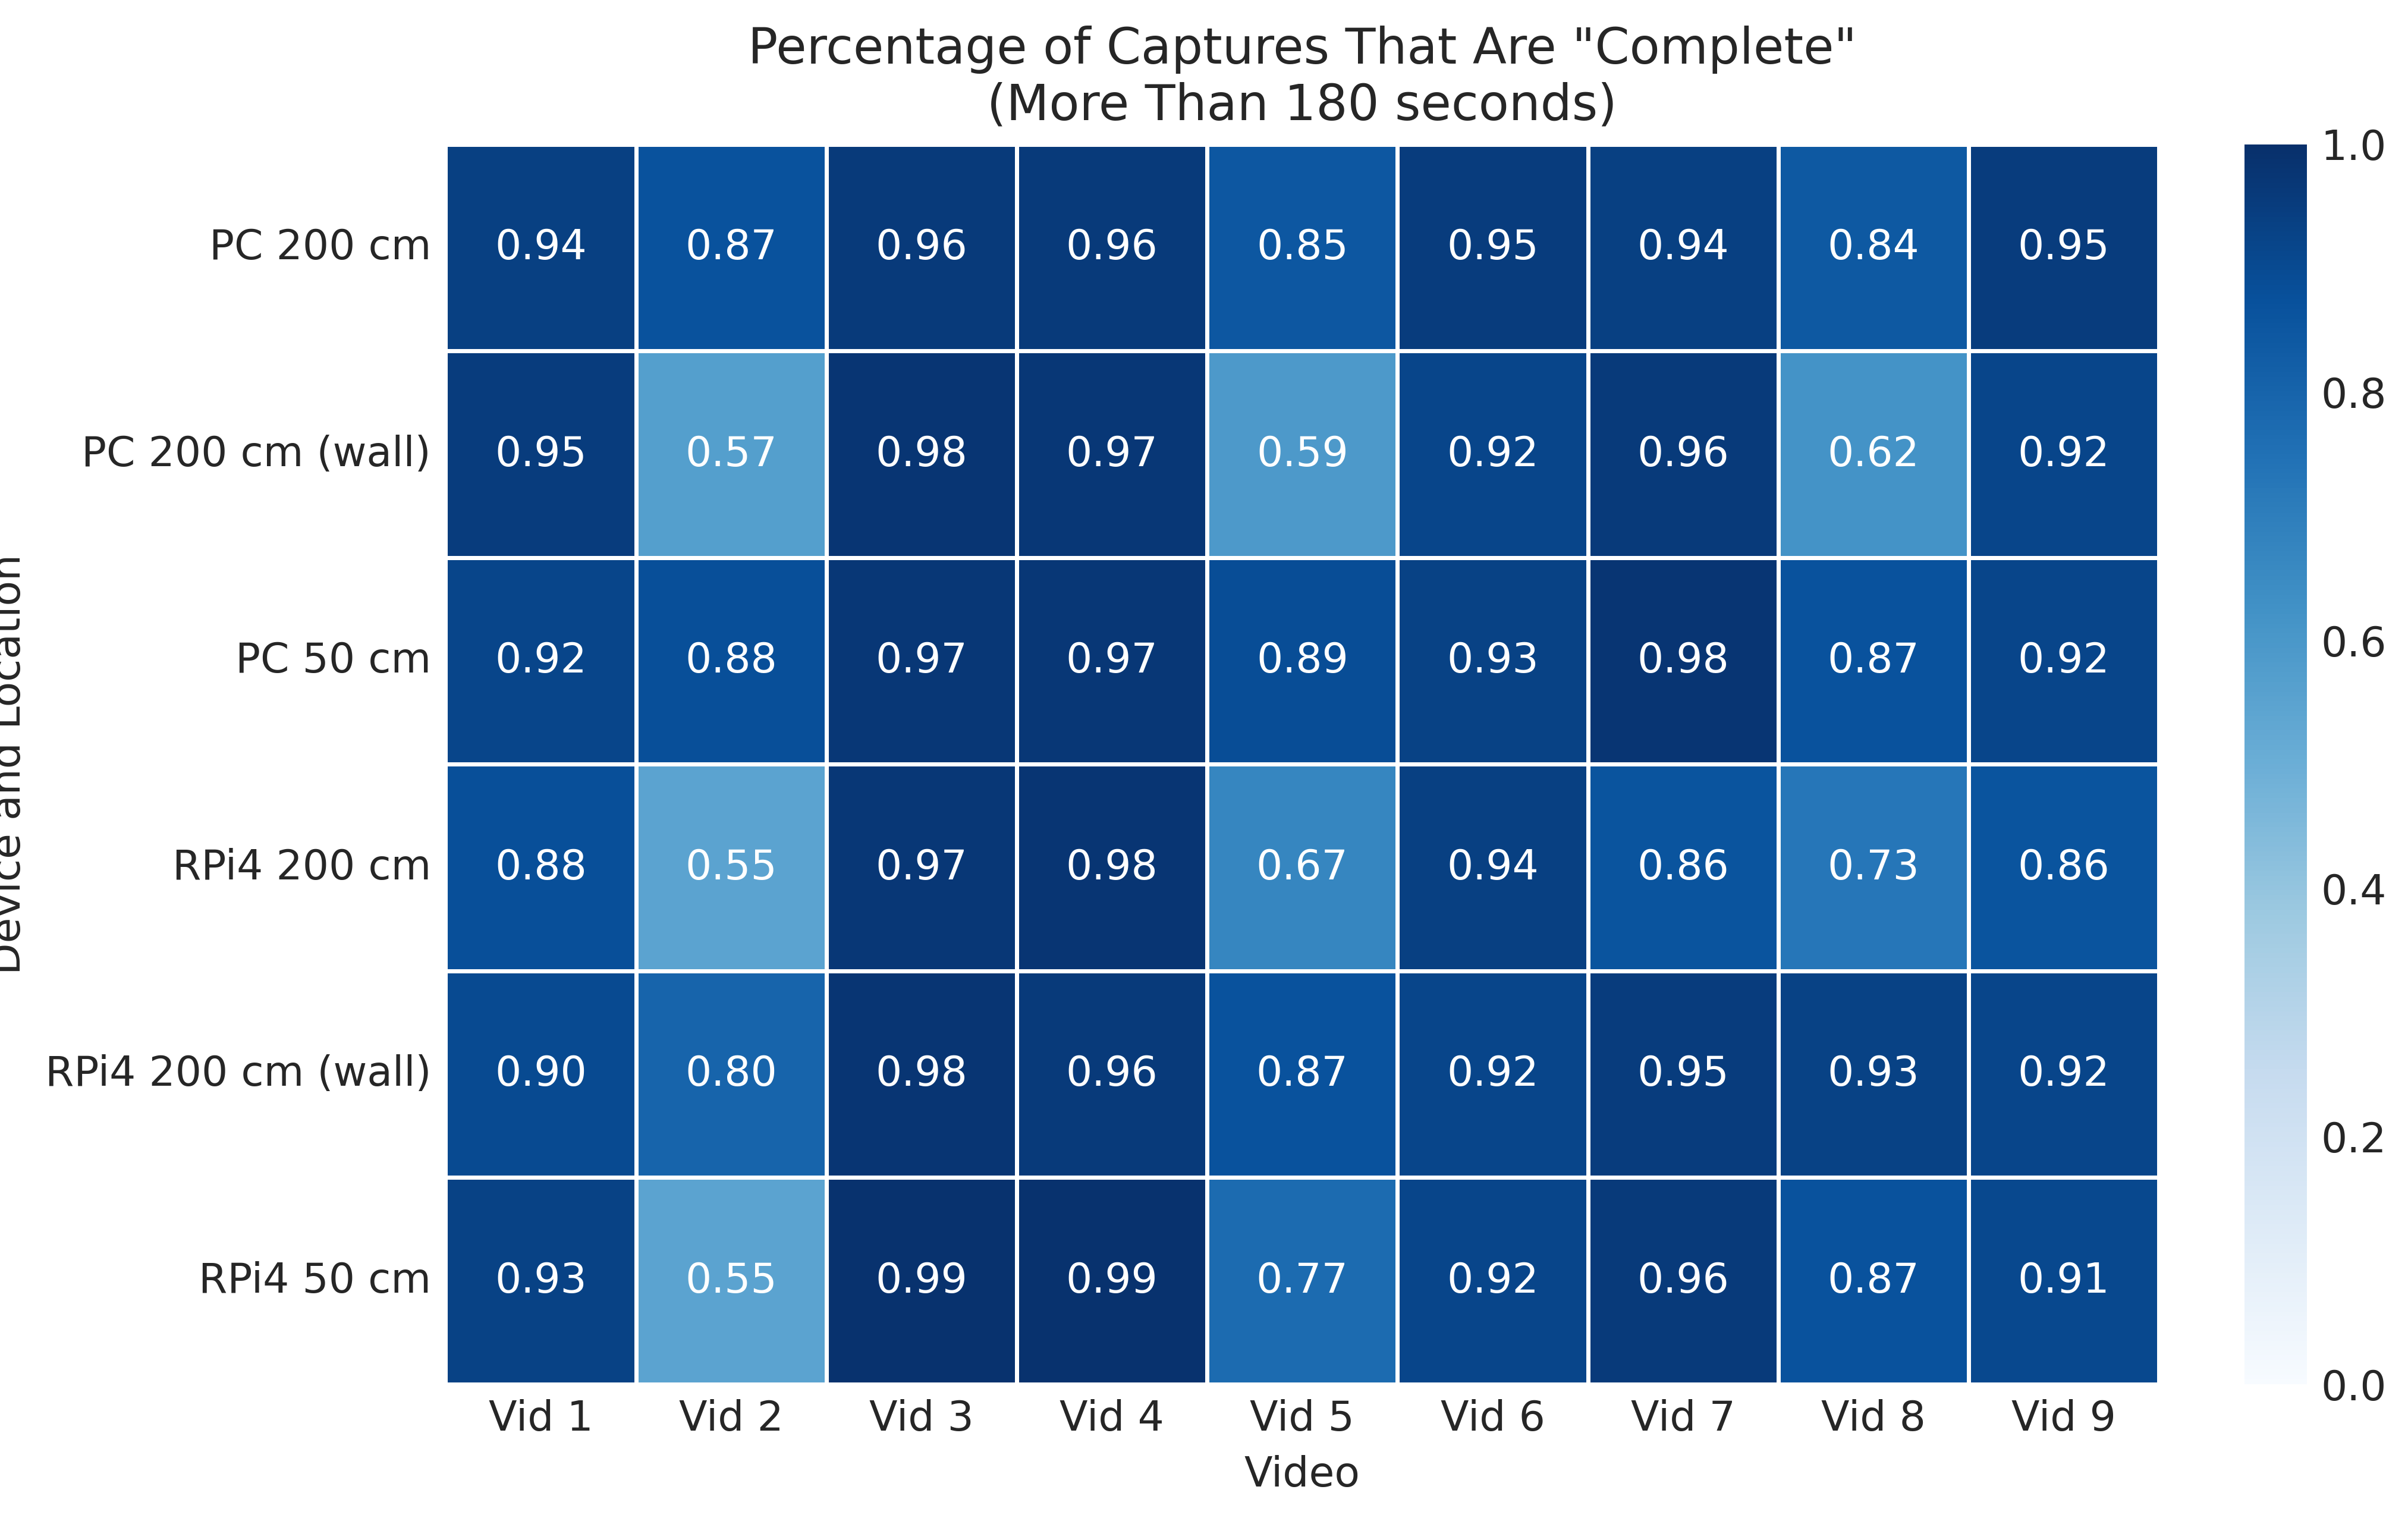

In [ ]:
with plt.style.context(fig_style):
    fig = plt.figure(figsize=(8, 5), layout="constrained")
    ax = fig.subplots()
    sns.heatmap(
        (
            X_comb_features
            .index
            .to_frame(index=False)
            .groupby(["devices", "videos"])
            .count()
            .reset_index()
            .pivot(index="devices", columns="videos", values="instances")
        )/100,
        vmin=0,
        vmax=1,
        cmap="Blues",
        annot=True,
        fmt=".2f",
        cbar=True,
        linewidth=1,
        linecolor="White",
        ax=ax,
    )
    ax.set(title="Percentage of Captures That Are \"Complete\"\n(More Than 180 seconds)", xlabel="Video", ylabel="Device and Location")
    fig.savefig(os.path.join(plt_dir, "captures_success_percentage.png"))

### Setting Y Labels

In [ ]:
# Making a DF of the corresponding label combinations of each sample
# Columns: devices, locations, videos, instances
Y = (
    X_comb_features
    .index
    .to_frame()
    .reset_index(drop=True)
    .assign(
        locations=lambda x: x["devices"].str.split(" ").str[1:].str.join(" "),
        devices=lambda x: x["devices"].str.split(" ").str[0],
    )
    .reindex(
        columns=["devices", "locations", "videos", "instances"],
    )
)

# SPECIFY LABELS TO USE
labels_to_classify = [
    "devices",
    "locations",
    "videos",
]

# Making label combos to use
y = np.array(
    ["|".join(x) for x in Y[labels_to_classify].values]
)

# Encode the labels
# le = LabelEncoder() # assigns integer encoding
lb = LabelBinarizer() # one-hot encoding|
lb.fit(y)
y_lb = lb.transform(y)

y

array(['PC|200 cm|Vid 1', 'PC|200 cm|Vid 1', 'PC|200 cm|Vid 1', ...,
       'RPi4|50 cm|Vid 9', 'RPi4|50 cm|Vid 9', 'RPi4|50 cm|Vid 9'],
      dtype='<U24')

## Making X features matrix

In [ ]:
# Making a 3D features matrix
# Axes format is (instance, time, feature_channel)
X_features_matr = (
    np.array(
        X_comb_features.values.tolist()
    )
    .transpose(0, 2, 1)
)

# MinMax scaling the 2D matrix of each feature channel
X_features_matr_scaled = np.zeros(X_features_matr.shape)
# For each feature channel (i.e., each entire (instance, time) matrix)
for i in np.arange(X_features_matr.shape[2]):
    view = X_features_matr[:, :, i]
    # Log transform
    # view = np.log1p(view)
    # MinMax Scale
    X_features_matr_scaled[:, :, i] = (view - view.min())/(view.max() - view.min())
# Set nan values to 0
X_features_matr_scaled[np.isnan(X_features_matr_scaled)] = 0

## Making Training and Test sets

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features_matr_scaled,
    y_lb,
    test_size=0.2,
    random_state=42,
    stratify=y_lb,
)

# Splitting the training and test features into the CSI and WLAN sets
X_train_csi = X_train[:, :, :len(X_csi_channels)]
X_train_wlan = X_train[:, :, len(X_csi_channels):]
X_test_csi = X_test[:, :, :len(X_csi_channels)]
X_test_wlan = X_test[:, :, len(X_csi_channels):]

ljust_n = 20
print("Training Inputs")
print("X_train_csi:".ljust(ljust_n), X_train_csi.shape)
print("X_train_wlan:".ljust(ljust_n), X_train_wlan.shape)
print("\nTesting Inputs")
print("X_test_csi:".ljust(ljust_n), X_test_csi.shape)
print("X_test_wlan:".ljust(ljust_n), X_test_wlan.shape)
print("\nOutputs")
print("y_train:".ljust(ljust_n), y_train.shape)
print("y_test:".ljust(ljust_n), y_test.shape)



Training Inputs
X_train_csi:         (3810, 500, 48)
X_train_wlan:        (3810, 500, 3)

Testing Inputs
X_test_csi:          (953, 500, 48)
X_test_wlan:         (953, 500, 3)

Outputs
y_train:             (3810, 54)
y_test:              (953, 54)


## Evaluating ML Models

### Helper Funcs to save and eval models

In [ ]:
def get_my_model_dir(
    name,
):
    """
    Returns the path to the model directory
    """
    # Making directory to store model
    outcomes = "_".join([i[0] for i in labels_to_classify]) # first letter of every class group
    my_model_dir = os.path.join(models_dir, outcomes, name)
    os.makedirs(my_model_dir, exist_ok=True)
    return my_model_dir


def save_pkl(
    obj,
    name,
    suffix=""
):
    """
    Saves the object as a .pkl file to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Storing object as pickle
    obj_fp = os.path.join(my_model_dir, f"{name}_{suffix}.pkl")
    with open(obj_fp, "wb") as f:
        pickle.dump(obj, f)


def load_pkl(
    name,
    suffix=""
):
    """
    Loads the .pkl file object from a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Getting filepaths
    obj_fp = os.path.join(my_model_dir, f"{name}_{suffix}.pkl")
    # Loading object
    with open(obj_fp, "rb") as f:
        obj = pickle.load(f)
    return obj


def save_res(
    y_true,
    y_pred,
    name,
):
    """
    Saves the results to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Generating and storing results as h5
    res_fp = os.path.join(my_model_dir, f"{name}_res.h5")
    pd.DataFrame(
        {
            "y_true": y_true,
            "y_pred": y_pred,
        }
    ).to_hdf(res_fp, key="results", mode="w")


def plot_confusion_matrix(
    cm,
    classes,
    title='Confusion matrix',
    **kwargs
):
    """
    To plot heatmap of confusion matrix
    """
    # Initialising figure and axes
    with plt.style.context(fig_style):
        fig = plt.figure(
            figsize=(8, 8),
            layout="constrained"
        )
        ax = fig.subplots()
    # Making confusion matrix heatmap
    sns.heatmap(
        cm,
        annot=kwargs.get("annot", False),
        ax=ax,
        cmap=kwargs.get("cmap", cmap_intsy),
        fmt=kwargs.get("fmt", ".2f"),
        cbar=kwargs.get("cbar", True),
        xticklabels=classes,
        yticklabels=classes,
    )
    # Set titles
    ax.tick_params(labelsize="small")
    ax.set_title(title, fontsize="xx-large")
    ax.set_xlabel("Predicted", fontsize="large")
    ax.set_ylabel("True", fontsize="large")
    # Return figure and axis
    return fig, ax

def eval_model(
    name,
    lab_grouping=None,
):
    """
    Evaluate the given model from the saved results h5.
    Can also group on the given labels (e.g., only (devices, videos))
    """
    my_model_dir = get_my_model_dir(name)
    # Reading in results
    res = pd.read_hdf(
        os.path.join(my_model_dir, f"{name}_res.h5"),
        key="results",
        more="r"
    )
    # Making label groupings in results df for evaluation
    lab_grouping_str = ""
    if lab_grouping:
        # Making label groupings in results df for evaluation
        res = res.assign(
            y_true=lambda x: ["|".join(i) for i in np.array(res["y_true"].str.split("|").values.tolist())[:, lab_grouping]],
            y_pred=lambda x: ["|".join(i) for i in np.array(res["y_pred"].str.split("|").values.tolist())[:, lab_grouping]],
        )
        # Making label_grouping_str to individually save results to
        lab_grouping_str = "".join([str(i) for i in lab_grouping])

    # Getting classes
    classes = np.sort(res["y_true"].unique())

    # Making confusion matrix
    # rows = true, columns = predicted
    cm = confusion_matrix(
        y_true=res["y_true"],
        y_pred=res["y_pred"],
        labels=classes,
        normalize=None,
    )
    # Plotting confusion matrix
    fig, ax = plot_confusion_matrix(
        cm,
        classes,
        title=f"{name} Classifier Results",
        annot=True,
        cmap="Blues",
        fmt=".0f",
    )
    fig.savefig(os.path.join(my_model_dir, f"{name}_cm_{lab_grouping_str}.png"))
    # Classification report
    print(classification_report(
        res["y_true"],
        res["y_pred"],
        target_names=classes,
    ))
    (
        pd.DataFrame(
            classification_report(
                res["y_true"],
                res["y_pred"],
                target_names=classes,
                output_dict=True,
            ),
        )
        .transpose()
        .to_csv(os.path.join(my_model_dir, f"{name}_report_{lab_grouping_str}.csv"))
    )


## Deep Learning Models

In [ ]:
def save_model_tf(
    model,
    name,

):
    """
    Saves the TensorFlow Keras model to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Storing model as .keras
    model_fp = os.path.join(my_model_dir, f"{name}.keras")
    model.save(model_fp)

def save_weights_tf(
    model,
    name,
):
    """
    Saves the TensorFlow Keras model weights to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Storing model as .keras
    weights_fp = os.path.join(my_model_dir, f"{name}")
    model.save_weights(weights_fp)


def save_architecture_tf(
    model,
    name
):
    """
    Saves the TensorFlow Keras model architecture to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Saving architecture diagram
    archt_fp = os.path.join(my_model_dir, f"{name}.png")
    tf_plot(
        model,
        to_file=archt_fp,
        show_shapes=True,
        show_dtype=False,
        show_layer_names=False,
        rankdir="TB",
        expand_nested=True,
        dpi=500,
        show_layer_activations=True,
        show_trainable=False,
    )


def load_model_tf(
    name,
    load_weights=True,
):
    """
    Loads the TensorFlow Keras model from a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Getting filepaths
    model_fp = os.path.join(my_model_dir, f"{name}.keras")
    weights_fp = os.path.join(my_model_dir, f"{name}")
    # Loading model
    model = tf_load_model(model_fp)
    # Loading best weights
    if load_weights:
        try:
            model.load_weights(weights_fp)
        except:
            pass
    return model


def train_tf(
    name,
    hparams,
    X_train,
    y_train,
):
    """
    Trains a TensorFlow Keras model.
    Steps are:
        - Configure the model for training
        - Training the model
        - Saving the model
    """
    my_model_dir = get_my_model_dir(name)
    # Loading model
    model = load_model_tf(name, load_weights=False)

    # Remove old weights
    for i in ["checkpoint", ".index", ".data"]:
        fps = glob(os.path.join(my_model_dir, f"*{i}*"))
        [os.remove(fp) for fp in fps]

    # Configure the model for training
    model.compile(
        optimizer=Adam(
            learning_rate=hparams["learning_rate"],
        ),
        loss=hparams["loss"],
        metrics=[
            CategoricalAccuracy(),
            BinaryAccuracy(),
        ],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
        steps_per_execution=None,
        jit_compile=None,
        # pss_evaluation_shards=0,
    )

    # Training the model
    history = model.fit(
        X_train,
        y_train,
        epochs=hparams["epochs"],
        batch_size=hparams["batch_size"],
        validation_split=hparams["validation_split"],
        verbose=hparams["verbose"],
        callbacks=[
            ModelCheckpoint(
                filepath=os.path.join(get_my_model_dir(name), f"{name}"),
                verbose=1,
                save_weights_only=True,
                save_freq="epoch",
                monitor=hparams["checkpoint_monitor"],
                mode="auto",
                save_best_only=True,
            ),
            # EarlyStopping(
            #     monitor=hparams["stopping_monitor"],
            #     min_delta=0,
            #     patience=50,
            #     verbose=1,
            #     mode="auto",
            #     baseline=0,
            #     restore_best_weights=True,
            #     start_from_epoch=0,
            # ),
        ],
        use_multiprocessing=True,
    )

    # Saving the model
    save_model_tf(model, name)
    # Saving model history
    save_pkl(
        history,
        name,
        suffix="history",
    )
    # Saving model hyperparams
    save_pkl(
        hparams,
        name,
        suffix="hparams",
    )

def plot_training_history(
    name,
    metrics=["loss", "categorical_accuracy"],
):
    """
    """
    # Showing training convergence
    # Loading history
    history = load_pkl(name, suffix="history")
    h = pd.DataFrame(history.history)
    # Plotting training accuracy and loss convergence
    with plt.style.context(fig_style):
        fig = plt.figure(figsize=(8, 5), layout="constrained")
        axes = fig.subplots(nrows=len(metrics))
    for i_k, i_v in enumerate(metrics):
        sns.lineplot(
            data=(
                h[[f"{j}{i_v}" for j in ["", "val_"]]]
                .melt(
                    var_name="variable",
                    value_name="value",
                    ignore_index=False)
                .reset_index(
                    names="epoch",
                )
            ),
            x="epoch",
            y="value",
            hue="variable",
            palette=cmap_qual,
            ax=axes[i_k],
        )
        axes[i_k].set_title(f"{i_v}")
    return fig, axes


def eval_tf(
    name,
    X_test,
    y_test,
    lab_grouping=None,
    metrics=["loss", "categorical_accuracy"],
):
    """
    Evaluates a TensorFlow Keras model.
    Steps are:
        - Evaluating (from saved model)
        - Saving the results
        - Showing results
    """
    my_model_dir = get_my_model_dir(name)
    # Loading model
    model = load_model_tf(name)

    # Predicting the test labels
    y_pred = model.predict(X_test)

    # Saving the results
    save_res(
        lb.inverse_transform(y_test),
        lb.inverse_transform(y_pred),
        name,
    )
    # Showing results
    eval_model(name, lab_grouping)


### XL-NTA Model V1

In [ ]:
# CSI BRANCH
in_csi = Input(
    shape=X_train_csi.shape[1:],
    name="input_csi",
)
csi_branch = Sequential(
    [
        Reshape(
            (*in_csi.shape[1:], 1),
            name="reshape_1",
        ),
        Conv2D(
            16, (3, 3), 1, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling2D(
            2, name="maxpool_1",
        ),
        Conv2D(
            32, (1, 1), 1, padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling2D(
            2, name="maxpool_2",
        ),
        Conv2D(
            16, (3, 3), 1, padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling2D(
            2, name="maxpool_3",
        ),
        Dropout(
            0.5, name="dropout_2"
        ),
    ],
    name="CSI_branch",
)(in_csi)

# WLAN BRANCH
in_wlan = Input(
    shape=X_train_wlan.shape[1:],
    name="input_wlan",
)
wlan_branch = Sequential(
    [
        Conv1D(
            16, 5, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling1D(
            2, name="maxpool_2",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling1D(
            2, name="maxpool_3",
        ),
        Reshape(
            # (121, 1, 16),
            (60, 1, 16),
            name="reshape_1",
        ),
        UpSampling2D(
            (1, 4),
            name="upsample_1",
        ),
    ],
    name="WLAN_branch",
)(in_wlan)

# Merging branches
conc_branches = Concatenate(
    axis=1,
    name="concat"
)([csi_branch, wlan_branch])

# Fully Connected Layers
output_branch = Sequential(
    [
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_3",
        ),
        Flatten(
            name="flatten",
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        # Dense(
        #     32, activation="relu", name="dense_2",
        # ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            len(lb.classes_), activation="softmax", name="output"
        ),
    ],
    name="output_branch",
)(conc_branches)


model = Model(
    inputs=[in_csi, in_wlan],
    outputs=[output_branch],
    name="XL-NTA",
)

model.summary(expand_nested=True)
print(np.product(model.layers[-1].output_shape[1:]))

Model: "XL-NTA"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_csi (InputLayer)      [(None, 500, 48)]            0         []                            
                                                                                                  
 input_mac (InputLayer)      [(None, 500, 3)]             0         []                            
                                                                                                  
 CSI_branch (Sequential)     (None, 61, 4, 16)            5328      ['input_csi[0][0]']           
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| reshape_1 (Reshape)        (None, 500, 48, 1)           0         []                           |
|                                                                                            

In [ ]:
name = "XL-NTA_V1"

# Hyper-parameters
hparams = {
    "epochs": 500,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
    "loss": CategoricalCrossentropy(),
    "checkpoint_monitor": "val_categorical_accuracy",
    "stopping_monitor":"val_categorical_accuracy",
}

# # Saving model
# save_model_tf(model, name)
# # Save architecture
# save_architecture_tf(model, name)

# # Training model
# train_tf(
#     name,
#     hparams,
#     [X_train_csi, X_train_wlan],
#     y_train,
# )

# Show training history
my_model_dir = get_my_model_dir(name)
fig, axes = plot_training_history(name)
fig.savefig(os.path.join(my_model_dir, f"{name}_history.png"))

# Evaluating model
# All labels
eval_tf(
    name,
    [X_test_csi, X_test_wlan],
    y_test,
    lab_grouping=None,
)
# devices
eval_tf(
    name,
    [X_test_csi, X_test_wlan],
    y_test,
    lab_grouping=[0],
)
# locations
eval_tf(
    name,
    [X_test_csi, X_test_wlan],
    y_test,
    lab_grouping=[1],
)
# videos
eval_tf(
    name,
    [X_test_csi, X_test_wlan],
    y_test,
    lab_grouping=[2],
)

Output hidden; open in https://colab.research.google.com to view.

### XL-NTA Model V2

In [ ]:
# CSI BRANCH
in_csi = Input(
    shape=X_train_csi.shape[1:],
    name="input_csi",
)
csi_branch = Sequential(
    [
        Reshape(
            (*in_csi.shape[1:], 1),
            name="reshape_1",
        ),
        Conv2D(
            16, (5, 3), 1, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling2D(
            2, name="maxpool_1",
        ),
        Conv2D(
            32, (4, 4), 1, padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling2D(
            2, name="maxpool_2",
        ),
        SpatialDropout2D(
            0.5, name="dropout_1"
        ),
        Conv2D(
            16, (3, 5), 1, padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling2D(
            2, name="maxpool_3",
        ),
    ],
    name="CSI_branch",
)(in_csi)

# WLAN BRANCH
in_wlan = Input(
    shape=X_train_wlan.shape[1:],
    name="input_wlan",
)
wlan_branch = Sequential(
    [
        Conv1D(
            16, (5,), padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Conv1D(
            16, (4,), padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling1D(
            2, name="maxpool_2",
        ),
        SpatialDropout1D(
            0.5, name="dropout_1"
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling1D(
            2, name="maxpool_3",
        ),
        Reshape(
            # (120, 1, 16),
            (60, 1, 16),
            name="reshape_1",
        ),
        UpSampling2D(
            (1, 2),
            name="upsample_1",
        ),
    ],
    name="WLAN_branch",
)(in_wlan)

# Merging branches
conc_branches = Concatenate(
    axis=2,
    name="concat",
)([csi_branch, wlan_branch])

# Fully Connected Layers
output_branch = Sequential(
    [
        Conv2D(
            16, (3, 3), padding="valid", activation="relu", name="conv_1",
        ),
        Flatten(
            name="flatten",
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            len(lb.classes_), activation="softmax", name="output",
        ),
    ],
    name="output_branch",
)(conc_branches)


model = Model(
    inputs=[in_csi, in_wlan],
    outputs=output_branch,
    name="XL-NTA",
)

model.summary(expand_nested=True)

Model: "XL-NTA"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_csi (InputLayer)      [(None, 500, 48)]            0         []                            
                                                                                                  
 input_wlan (InputLayer)     [(None, 500, 3)]             0         []                            
                                                                                                  
 CSI_branch (Sequential)     (None, 60, 3, 16)            16176     ['input_csi[0][0]']           
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| reshape_1 (Reshape)        (None, 500, 48, 1)           0         []                           |
|                                                                                            

In [ ]:
name = "XL-NTA_V2"

# Hyper-parameters
hparams = {
    "epochs": 500,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
    "loss": CategoricalCrossentropy(),
    "checkpoint_monitor": "val_categorical_accuracy",
    "stopping_monitor": "val_categorical_accuracy",
}

# # Saving model
# save_model_tf(model, name)
# # Save architecture
# save_architecture_tf(model, name)

# # Training model
# train_tf(
#     name,
#     hparams,
#     [X_train_csi, X_train_wlan],
#     y_train,
# )

# Show training history
my_model_dir = get_my_model_dir(name)
fig, axes = plot_training_history(name)
fig.savefig(os.path.join(my_model_dir, f"{name}_history.png"))

# Evaluating model
# All labels
eval_tf(
    name,
    [X_test_csi, X_test_wlan],
    y_test,
    lab_grouping=None,
)
# devices
eval_tf(
    name,
    [X_test_csi, X_test_wlan],
    y_test,
    lab_grouping=[0],
)
# locations
eval_tf(
    name,
    [X_test_csi, X_test_wlan],
    y_test,
    lab_grouping=[1],
)
# videos
eval_tf(
    name,
    [X_test_csi, X_test_wlan],
    y_test,
    lab_grouping=[2],
)

Output hidden; open in https://colab.research.google.com to view.

### XL-NTA Model V3
PERFORMS BEST (0.92, 1.00, 0.97, 0.95)


In [ ]:
# CSI BRANCH
in_csi = Input(
    shape=X_train_csi.shape[1:],
    name="input_csi",
)
csi_branch = Sequential(
    [
        Reshape(
            (*in_csi.shape[1:], 1),
            name="reshape_1",
        ),
        Conv2D(
            16, (5, 3), 1, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling2D(
            2, name="maxpool_1",
        ),
        Conv2D(
            32, (4, 4), 1, padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling2D(
            2, name="maxpool_2",
        ),
        SpatialDropout2D(
            0.5, name="dropout_1"
        ),
        Conv2D(
            16, (3, 5), 1, padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling2D(
            2, name="maxpool_3",
        ),
    ],
    name="CSI_branch",
)(in_csi)

# WLAN BRANCH
in_wlan = Input(
    shape=X_train_wlan.shape[1:],
    name="input_wlan",
)
wlan_branch = Sequential(
    [
        Conv1D(
            16, (5,), padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Conv1D(
            16, (4,), padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling1D(
            2, name="maxpool_2",
        ),
        SpatialDropout1D(
            0.5, name="dropout_1"
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling1D(
            2, name="maxpool_3",
        ),
        Reshape(
            (60, 1, 16),
            name="reshape_1",
        ),
        UpSampling2D(
            (1, 2),
            name="upsample_1",
        ),
    ],
    name="WLAN_branch",
)(in_wlan)

# Merging branches
conc_branches = Concatenate(
    axis=2,
    name="concat",
)([csi_branch, wlan_branch])

# Fully Connected Layers
location_branch = Sequential(
    [
        Conv2D(
            16, (3, 3), padding="valid", activation="relu", name="conv_1",
        ),
        Flatten(
            name="flatten",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_2"
        ),
        Dense(
            6, activation="softmax", name="output",
        ),
    ],
    name="location_branch",
)(conc_branches)
video_branch = Sequential(
    [
        Conv2D(
            16, (3, 3), padding="valid", activation="relu", name="conv_1",
        ),
        Flatten(
            name="flatten",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_2"
        ),
        Dense(
            9, activation="softmax", name="output",
        ),
    ],
    name="video_branch",
)(conc_branches)


model = Model(
    inputs=[in_csi, in_wlan],
    outputs=[location_branch, video_branch],
    name="XL-NTA",
)

model.summary(expand_nested=True)

Model: "XL-NTA"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_csi (InputLayer)      [(None, 500, 48)]            0         []                            
                                                                                                  
 input_wlan (InputLayer)     [(None, 500, 3)]             0         []                            
                                                                                                  
 CSI_branch (Sequential)     (None, 60, 3, 16)            16176     ['input_csi[0][0]']           
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| reshape_1 (Reshape)        (None, 500, 48, 1)           0         []                           |
|                                                                                            

In [ ]:
# BEST MODEL!!! (1.00, 0.97, 0.95)
name = "XL-NTA" # "XL-NTA_V3"


# Making sub-labels
lb_l = LabelBinarizer()
lb_v = LabelBinarizer()
y_train_l = lb_l.fit_transform(["|".join(np.array(i.split("|"))[[0, 1]]) for i in lb.inverse_transform(y_train)])
y_test_l = lb_l.transform(["|".join(np.array(i.split("|"))[[0, 1]]) for i in lb.inverse_transform(y_test)])
y_train_v = lb_v.fit_transform(["|".join(np.array(i.split("|"))[[2]]) for i in lb.inverse_transform(y_train)])
y_test_v = lb_v.transform(["|".join(np.array(i.split("|"))[[2]]) for i in lb.inverse_transform(y_test)])
print(y_train_l.shape)
print(y_test_l.shape)
print(y_train_v.shape)
print(y_test_v.shape)


# Hyper-parameters
hparams = {
    "epochs": 500,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
    "loss": CategoricalCrossentropy(),
    "checkpoint_monitor": "val_loss",
    "stopping_monitor":"val_categorical_accuracy",
}

model = load_model_tf(name)
# Saving model
save_model_tf(model, name)
# Save architecture
save_architecture_tf(model, name)

# Training model
# train_tf(
#     name,
#     hparams,
#     [X_train_csi, X_train_wlan],
#     [y_train_l, y_train_v],
# )

model = load_model_tf(name)
# Predicting the test labels
y_pred_l, y_pred_v = model.predict([X_test_csi, X_test_wlan])
# Combining predicted labels
y_pred = lb.transform(
        [
        f"{i_l}|{i_v}"
        for i_l, i_v in np.array((
            lb_l.inverse_transform(y_pred_l),
            lb_v.inverse_transform(y_pred_v),
        )).T
    ]
)

# Saving the results
save_res(
    lb.inverse_transform(y_test),
    lb.inverse_transform(y_pred),
    name,
)

# Show training history
my_model_dir = get_my_model_dir(name)
fig, axes = plot_training_history(
    name,
    metrics=["loss", "location_branch_categorical_accuracy", "video_branch_categorical_accuracy"]
)
fig.savefig(os.path.join(my_model_dir, f"{name}_history.png"))

# Showing results
eval_model(name, [0, 1, 2])
eval_model(name, [0])
eval_model(name, [1])
eval_model(name, [2])


Output hidden; open in https://colab.research.google.com to view.

### XL-NTA V4

In [ ]:
# CSI BRANCH
in_csi = Input(
    shape=X_train_csi.shape[1:],
    name="input_csi",
)
csi_branch = Sequential(
    [
        Reshape(
            (*in_csi.shape[1:], 1),
            name="reshape_1",
        ),
        Conv2D(
            16, (5, 3), 1, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling2D(
            2, name="maxpool_1",
        ),
        Conv2D(
            32, (4, 4), 1, padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling2D(
            2, name="maxpool_2",
        ),
        SpatialDropout2D(
            0.5, name="dropout_1"
        ),
        Conv2D(
            16, (3, 5), 1, padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling2D(
            2, name="maxpool_3",
        ),
    ],
    name="CSI_branch",
)(in_csi)

# WLAN BRANCH
in_wlan = Input(
    shape=X_train_wlan.shape[1:],
    name="input_wlan",
)
wlan_branch = Sequential(
    [
        Conv1D(
            16, (5,), padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Conv1D(
            32, (4,), padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling1D(
            2, name="maxpool_2",
        ),
        SpatialDropout1D(
            0.5, name="dropout_1"
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_3",
        ),
        MaxPooling1D(
            2, name="maxpool_3",
        ),
        Reshape(
            (60, 1, 16),
            name="reshape_1",
        ),
        UpSampling2D(
            (1, 2),
            name="upsample_1",
        ),
    ],
    name="WLAN_branch",
)(in_wlan)

# Merging branches
conc_branches = Concatenate(
    axis=2,
    name="concat",
)([csi_branch, wlan_branch])

# Fully Connected Layers
location_branch = Sequential(
    [
        Conv2D(
            16, (3, 3), padding="valid", activation="relu", name="conv_1",
        ),
        Flatten(
            name="flatten",
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            6, activation="softmax", name="output",
        ),
    ],
    name="location_branch",
)(conc_branches)
video_branch = Sequential(
    [
        Conv2D(
            16, (3, 3), padding="valid", activation="relu", name="conv_1",
        ),
        Flatten(
            name="flatten",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dense(
            9, activation="softmax", name="output",
        ),
    ],
    name="video_branch",
)(conc_branches)


model = Model(
    inputs=[in_csi, in_wlan],
    outputs=[location_branch, video_branch],
    name="XL-NTA",
)

model.summary(expand_nested=True)

Model: "XL-NTA"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_csi (InputLayer)      [(None, 500, 48)]            0         []                            
                                                                                                  
 input_wlan (InputLayer)     [(None, 500, 3)]             0         []                            
                                                                                                  
 CSI_branch (Sequential)     (None, 60, 3, 16)            16176     ['input_csi[0][0]']           
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| reshape_1 (Reshape)        (None, 500, 48, 1)           0         []                           |
|                                                                                            

(3810, 6)
(953, 6)
(3810, 9)
(953, 9)
30/30 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

          PC       1.00      1.00      1.00       482
        RPi4       1.00      1.00      1.00       471

    accuracy                           1.00       953
   macro avg       1.00      1.00      1.00       953
weighted avg       1.00      1.00      1.00       953

               precision    recall  f1-score   support

       200 cm       0.95      0.91      0.93       315
200 cm (wall)       0.91      0.93      0.92       313
        50 cm       0.93      0.94      0.94       325

     accuracy                           0.93       953
    macro avg       0.93      0.93      0.93       953
 weighted avg       0.93      0.93      0.93       953

              precision    recall  f1-score   support

       Vid 1       0.92      0.94      0.93       111
       Vid 2       0.96      0.89      0.93        84
       Vid 3       0.93      0.

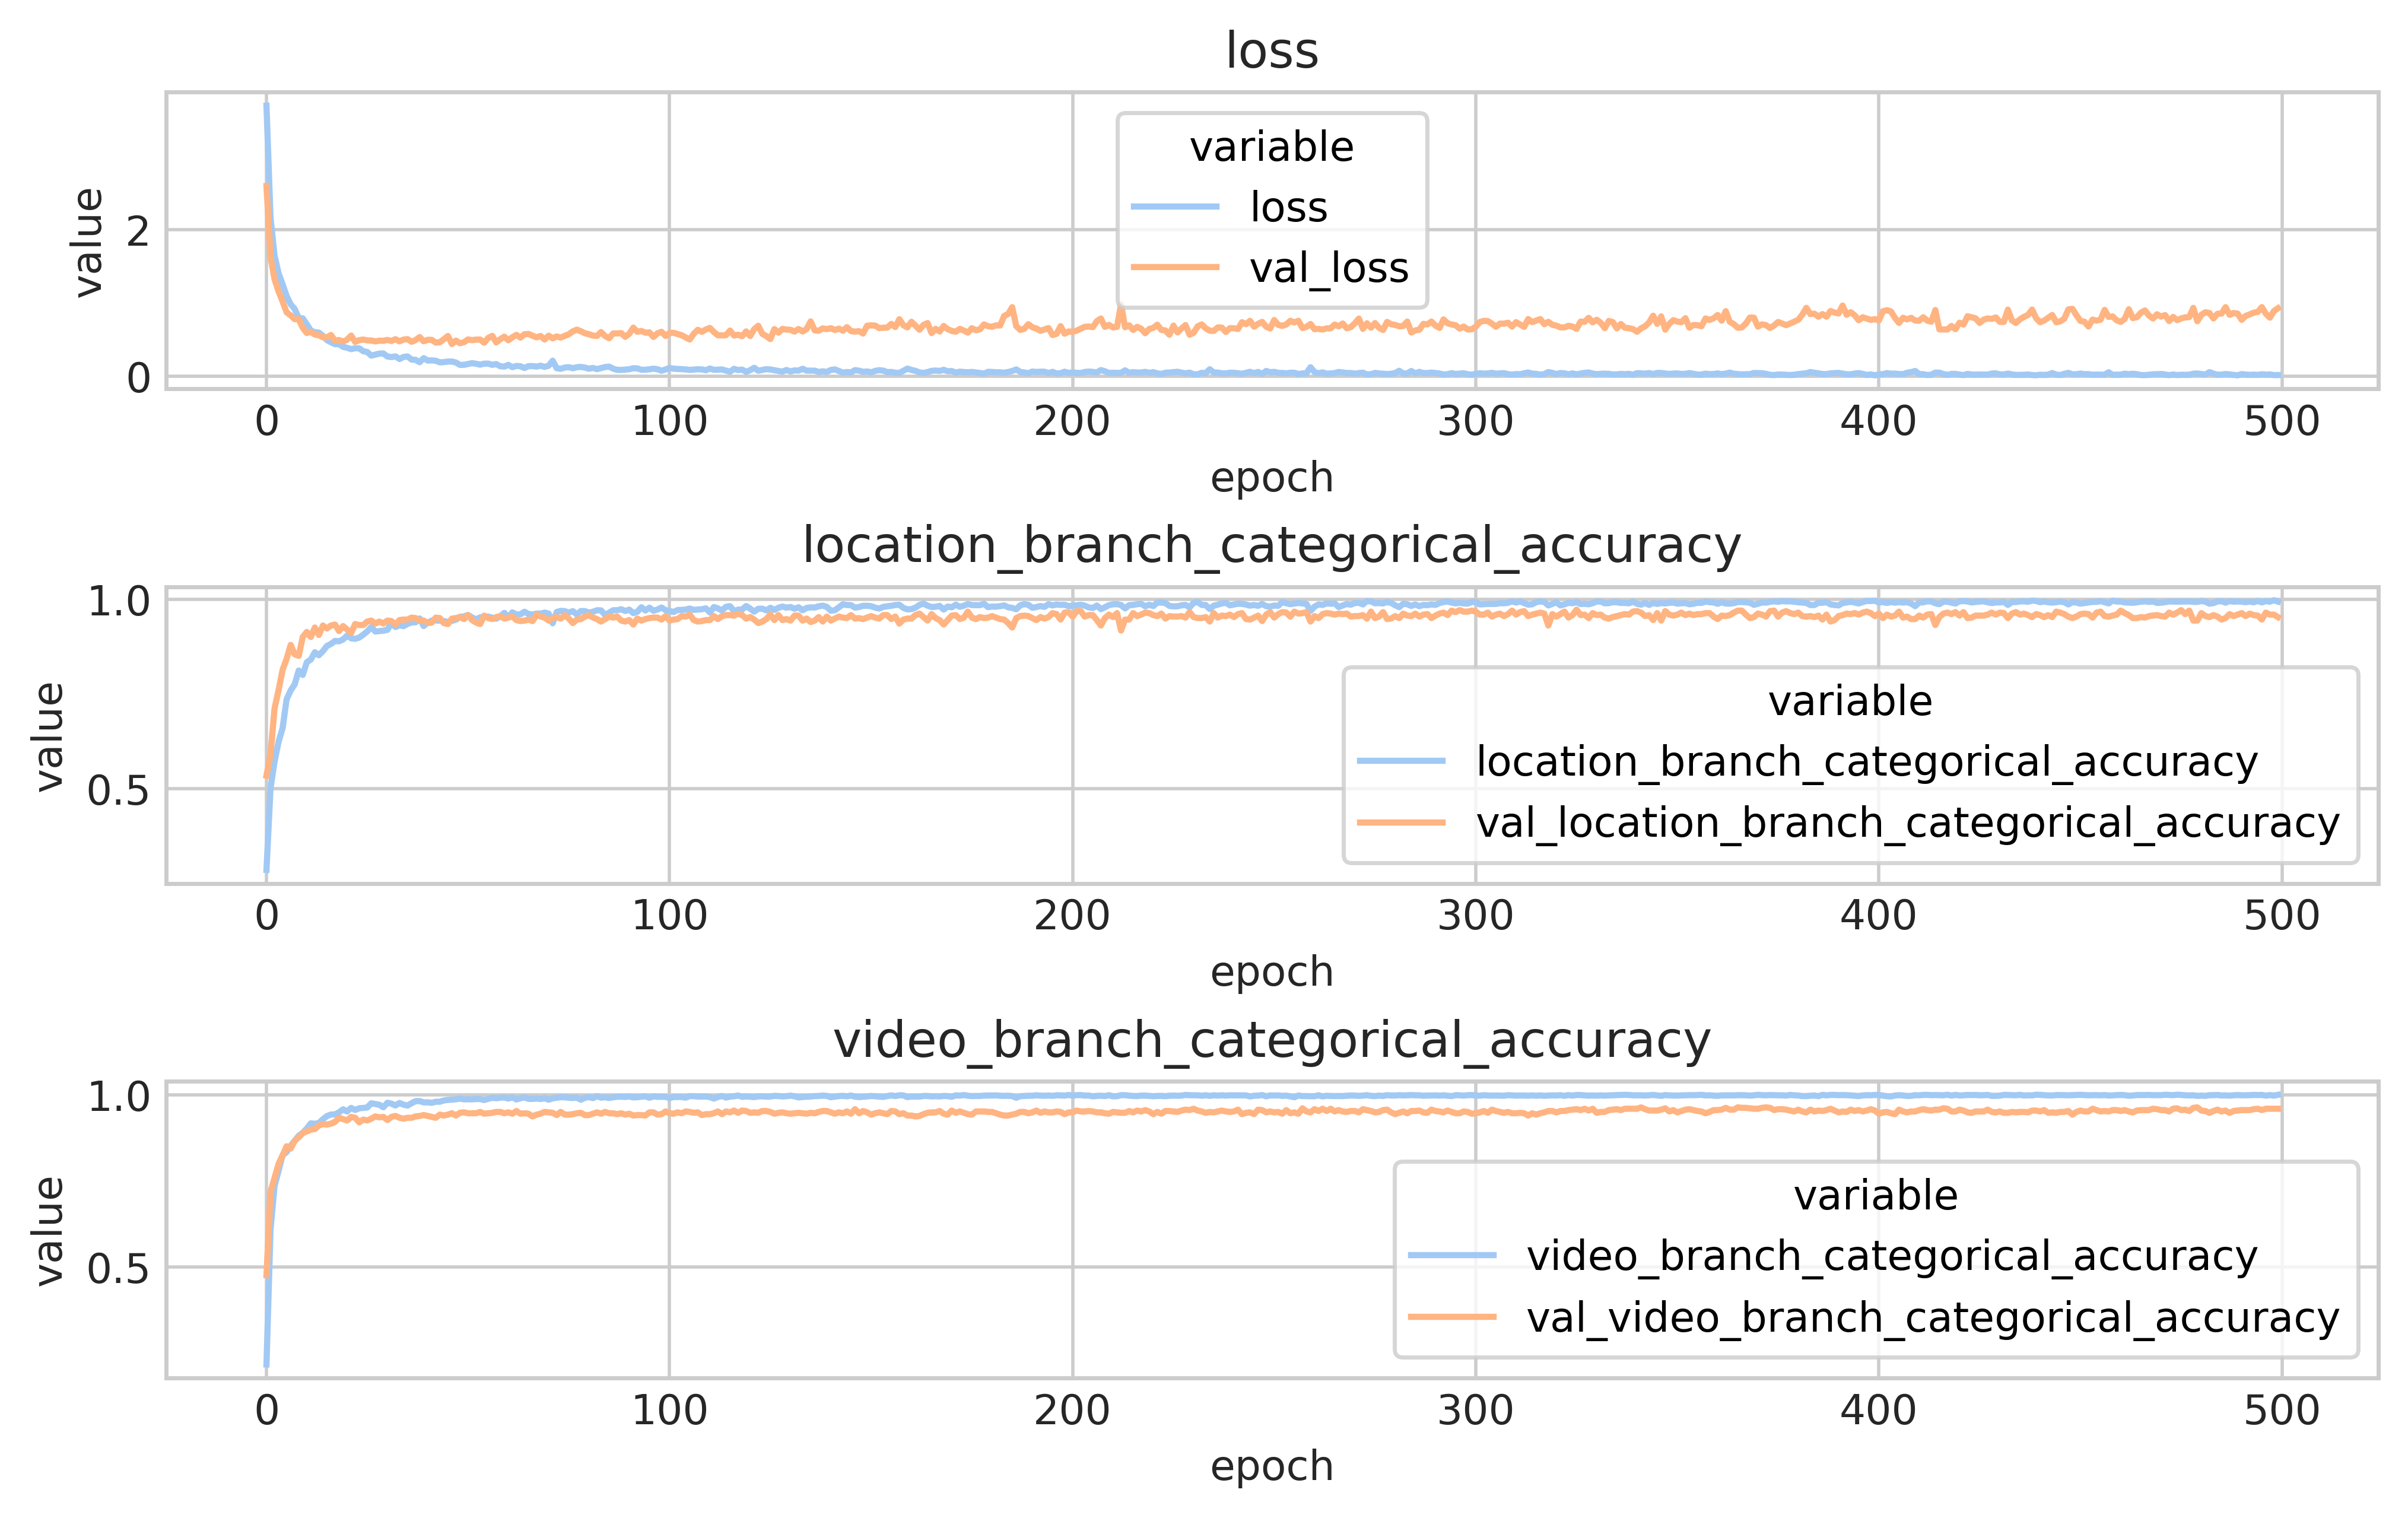

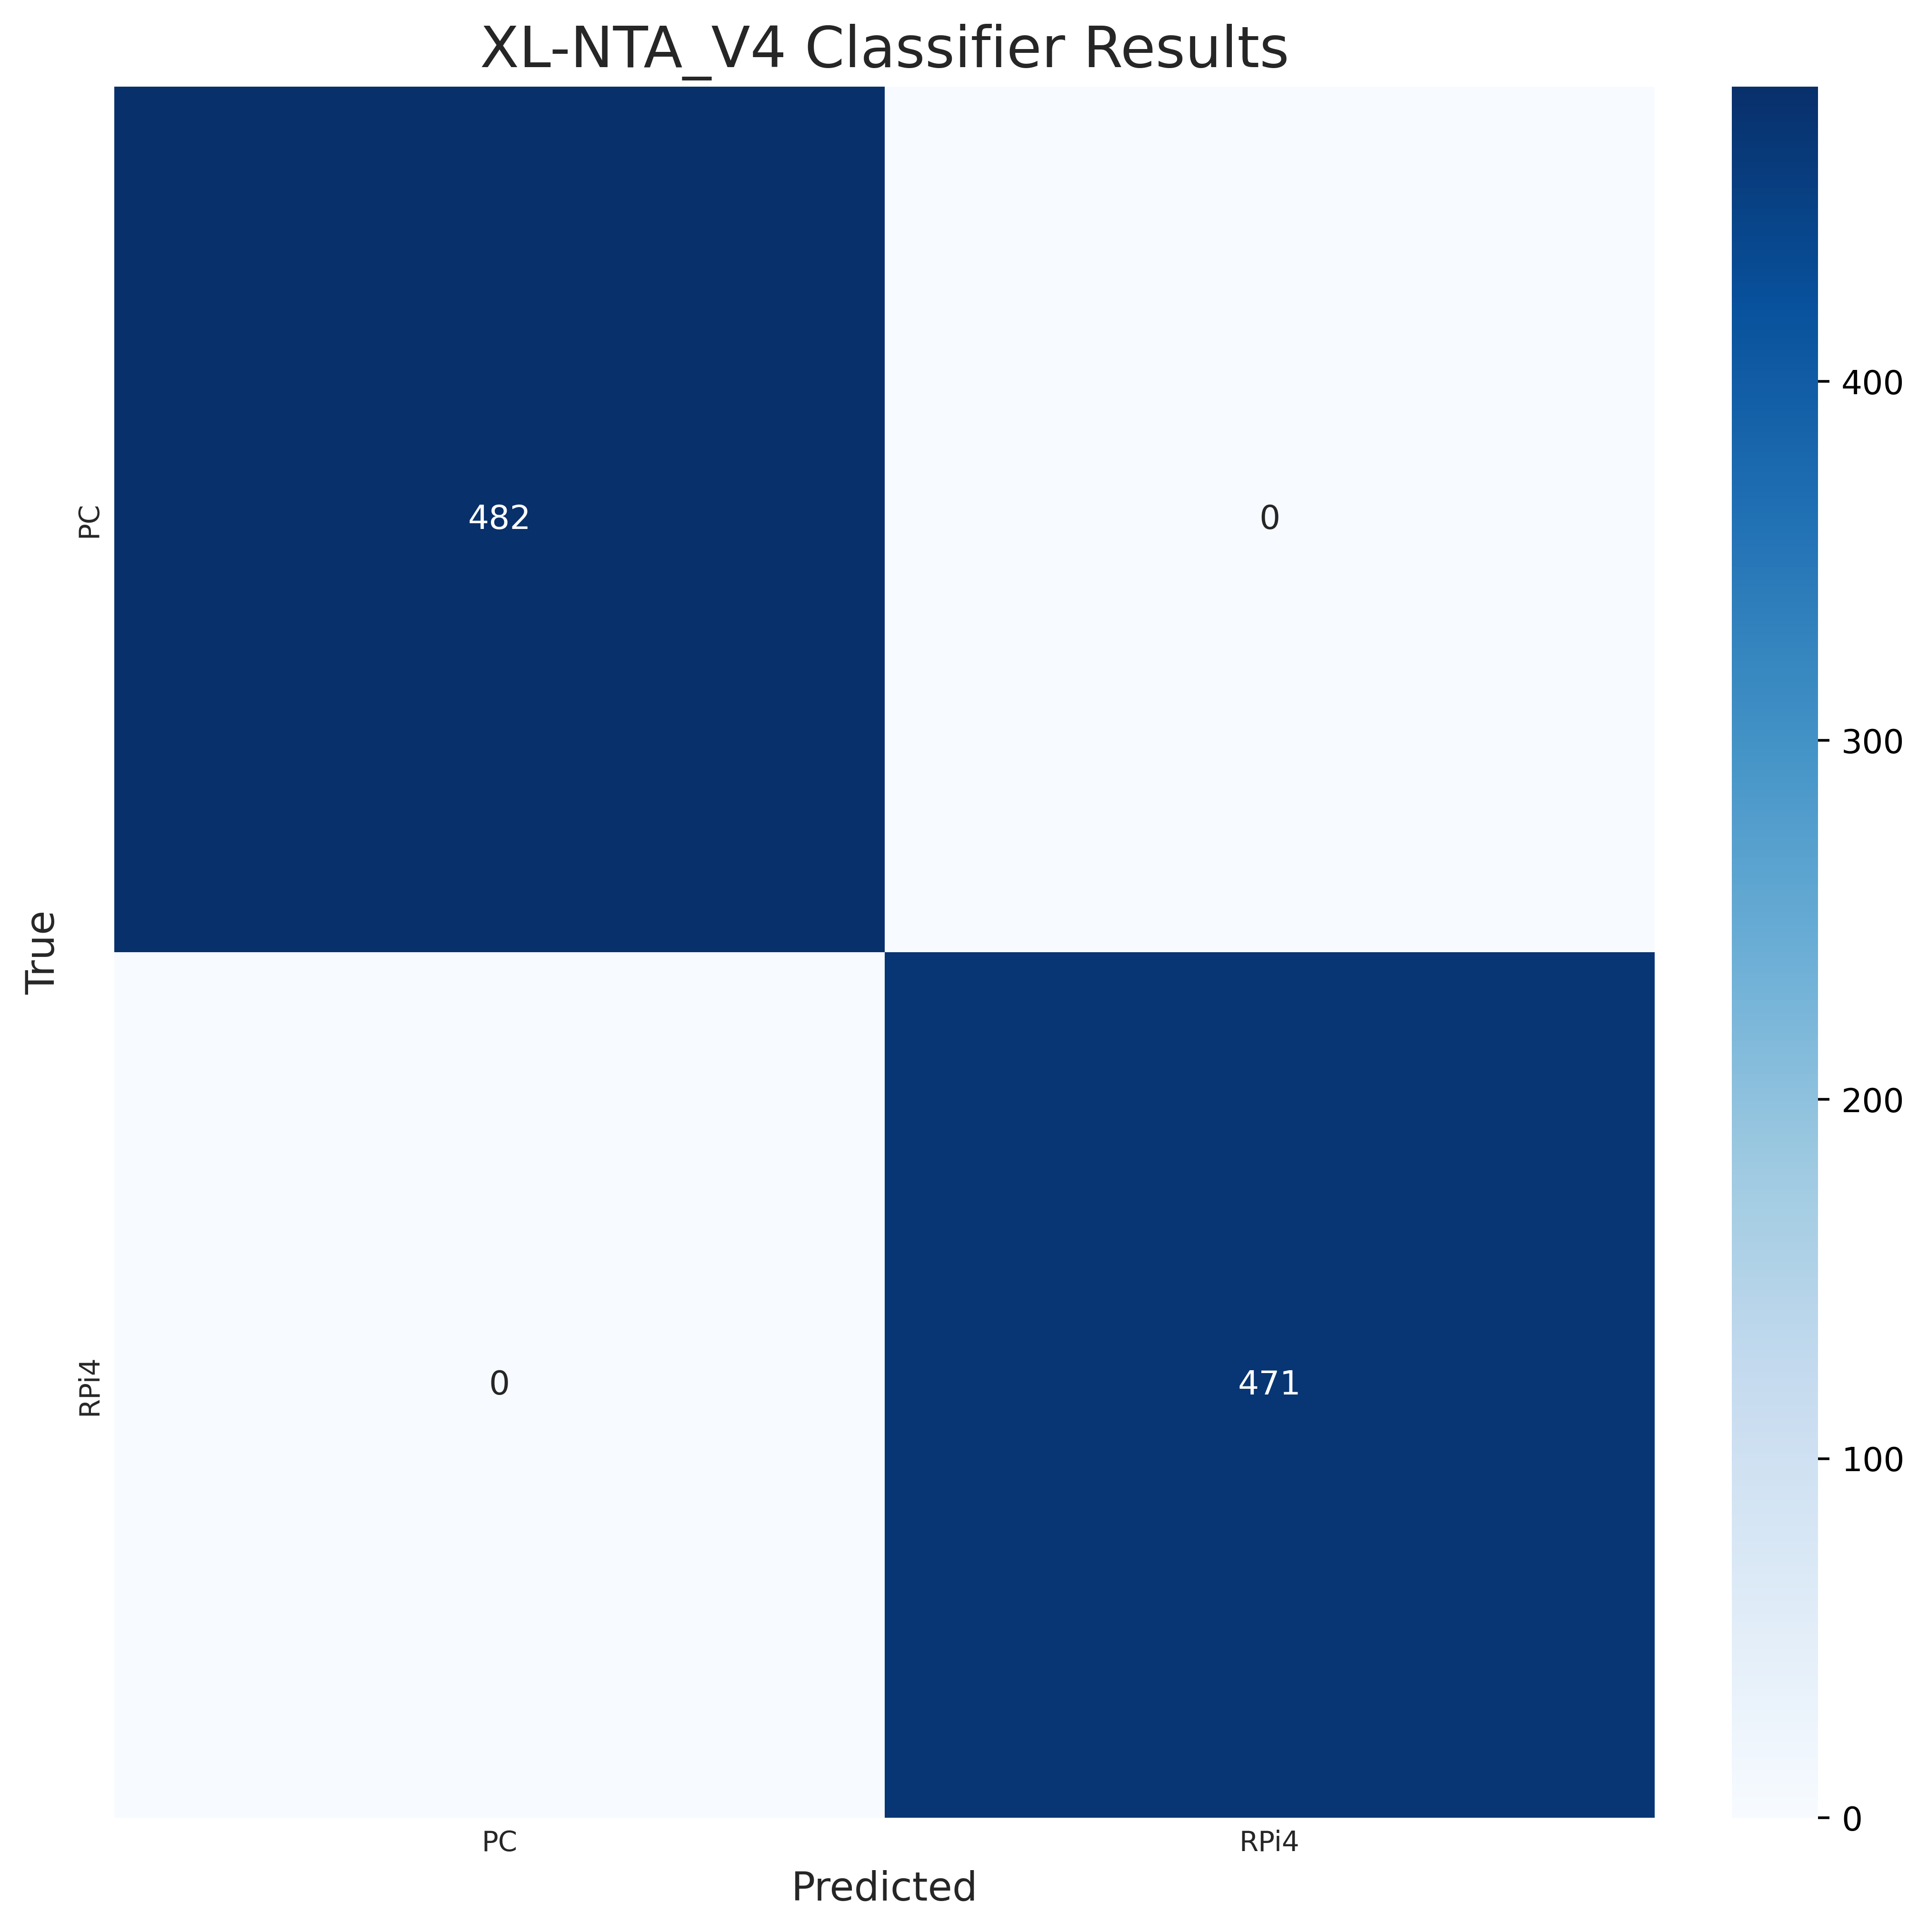

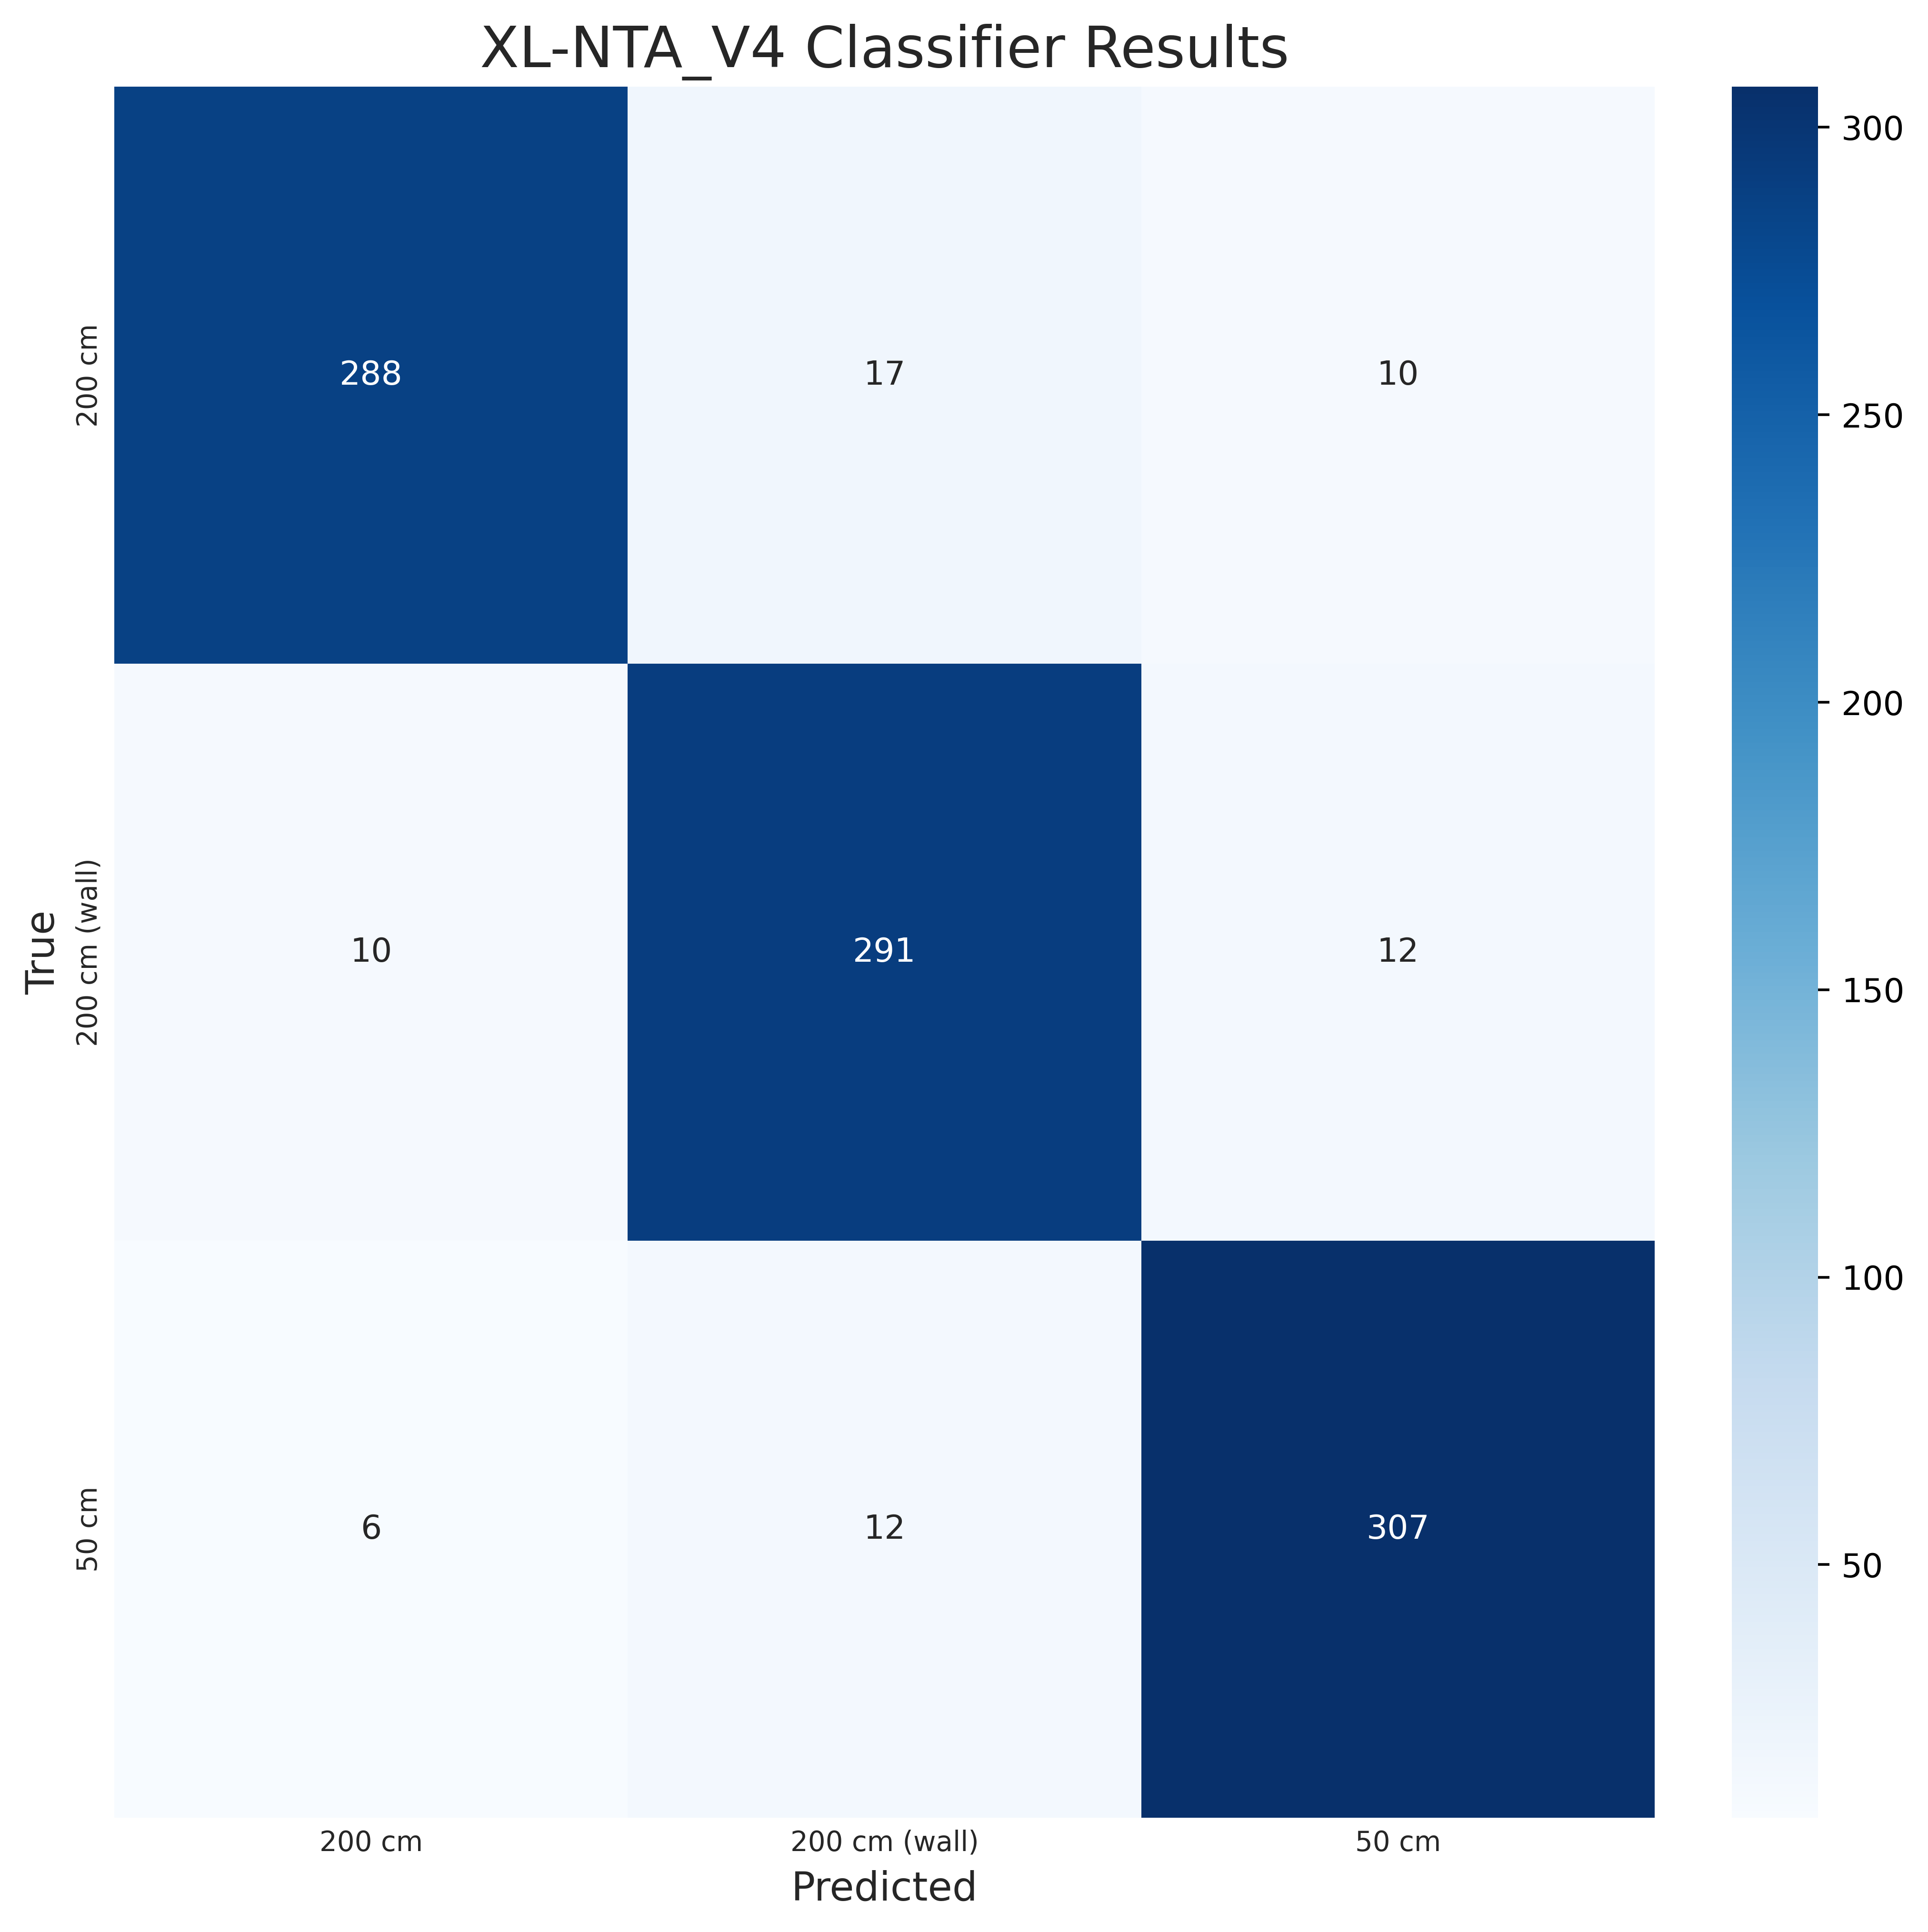

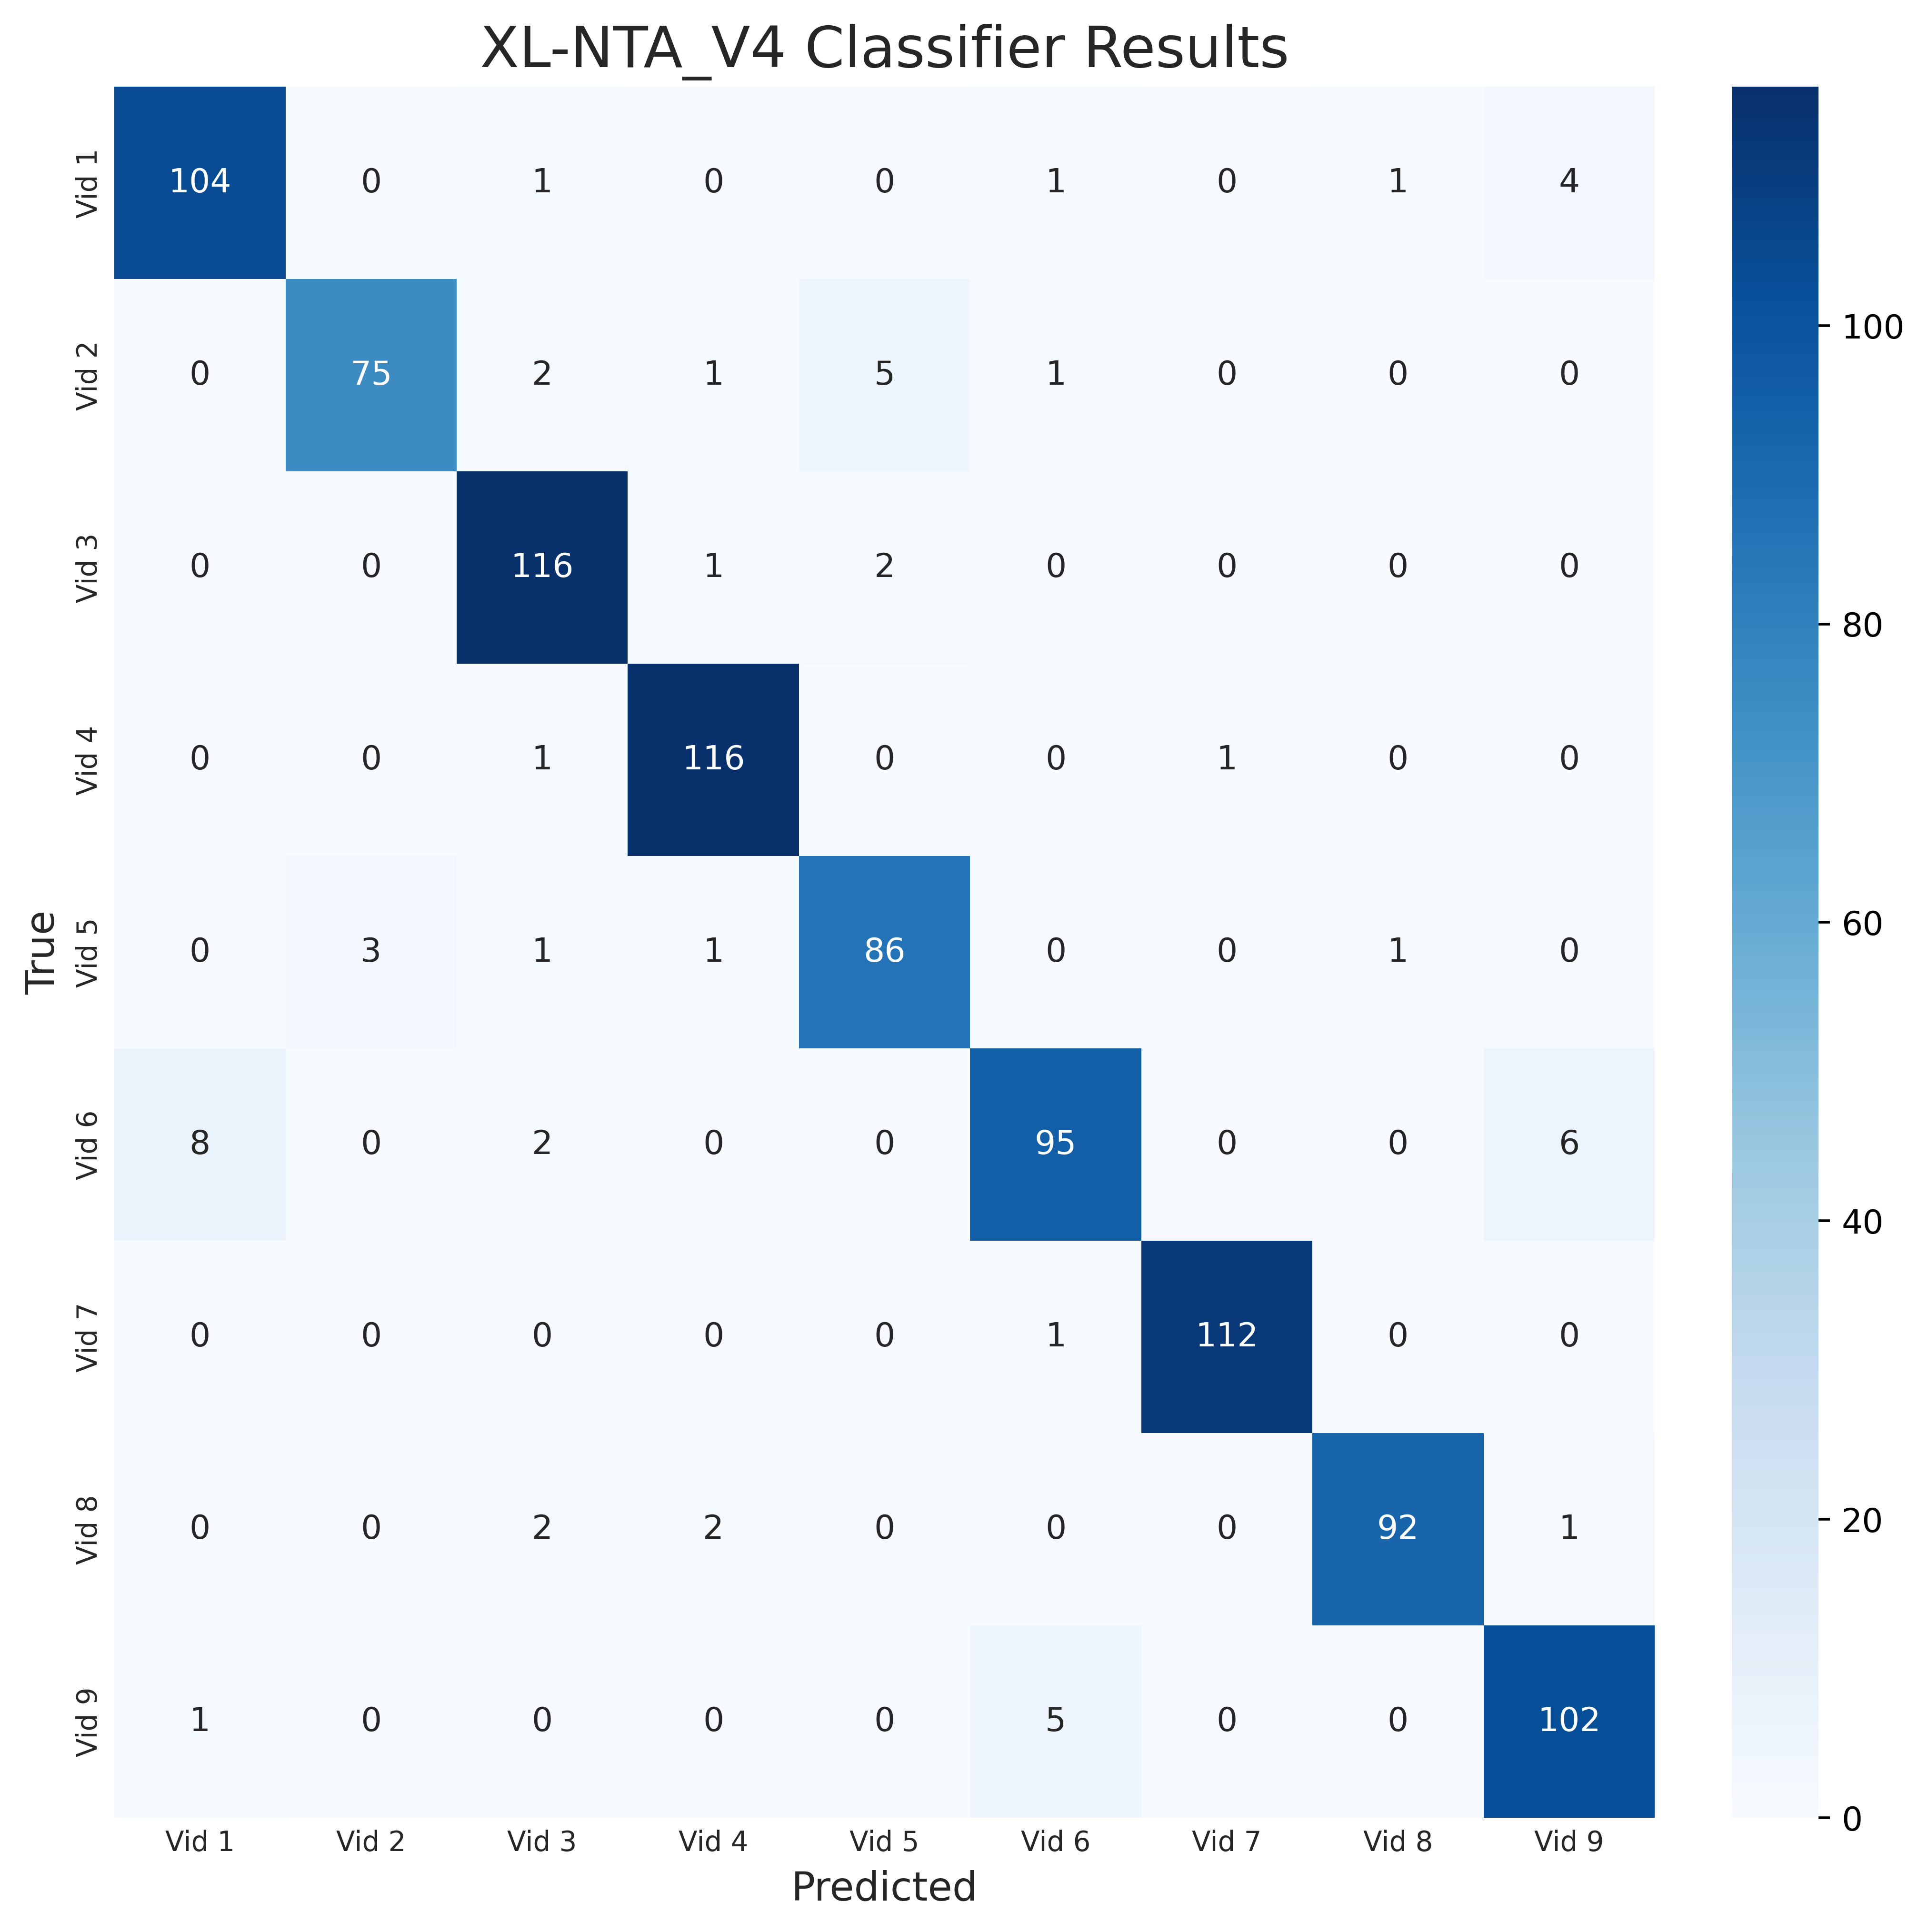

In [ ]:
name = "XL-NTA_V4"


# Making sub-labels
lb_l = LabelBinarizer()
lb_v = LabelBinarizer()
y_train_l = lb_l.fit_transform(["|".join(np.array(i.split("|"))[[0, 1]]) for i in lb.inverse_transform(y_train)])
y_test_l = lb_l.transform(["|".join(np.array(i.split("|"))[[0, 1]]) for i in lb.inverse_transform(y_test)])
y_train_v = lb_v.fit_transform(["|".join(np.array(i.split("|"))[[2]]) for i in lb.inverse_transform(y_train)])
y_test_v = lb_v.transform(["|".join(np.array(i.split("|"))[[2]]) for i in lb.inverse_transform(y_test)])
print(y_train_l.shape)
print(y_test_l.shape)
print(y_train_v.shape)
print(y_test_v.shape)


# Hyper-parameters
hparams = {
    "epochs": 500,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
    "loss": CategoricalCrossentropy(),
    "checkpoint_monitor": "val_loss",
    "stopping_monitor":"val_categorical_accuracy",
}

# Saving model
save_model_tf(model, name)
# Save architecture
save_architecture_tf(model, name)

# Training model
train_tf(
    name,
    hparams,
    [X_train_csi, X_train_wlan],
    [y_train_l, y_train_v],
)

model = load_model_tf(name)
# Predicting the test labels
y_pred_l, y_pred_v = model.predict([X_test_csi, X_test_wlan])
# Combining predicted labels
y_pred = lb.transform(
        [
        f"{i_l}|{i_v}"
        for i_l, i_v in np.array((
            lb_l.inverse_transform(y_pred_l),
            lb_v.inverse_transform(y_pred_v),
        )).T
    ]
)

# Saving the results
save_res(
    lb.inverse_transform(y_test),
    lb.inverse_transform(y_pred),
    name,
)

# Show training history
my_model_dir = get_my_model_dir(name)
fig, axes = plot_training_history(
    name,
    metrics=["loss", "location_branch_categorical_accuracy", "video_branch_categorical_accuracy"]
)
fig.savefig(os.path.join(my_model_dir, f"{name}_history.png"))

# Showing results
eval_model(name, [0])
eval_model(name, [1])
eval_model(name, [2])
